<a href="https://colab.research.google.com/github/benchov/Machine_Learning_for_Trading_Knowledge/blob/main/Market_Analysis_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kneed
!pip install alpaca-trade-api
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 8.9 MB/s 
     |████████████████████████████████| 322 kB 49.2 MB/s 
     |████████████████████████████████| 55 kB 3.7 MB/s 
     |████████████████████████████████| 1.3 MB 65.2 MB/s 
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.4
    Uninstalling msgpack-1.0.4:
      Successfully uninstalled msgpack-1.0.4
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.8.3
    Uninstalling aiohttp-3.8.3:
      Successfully uninstalled aiohttp-3.8.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.2 MB 5.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 5.5 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.1 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 110 kB 39.2 MB/s 
     |████████████████████████████████| 4.0 MB 66.9 MB/s 
     |████████████████████████████████| 112 kB 63.6 MB/s 
     |████████████████████████████████| 128 kB 63.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: html5lib
    Found

### Market Analysis for Paper Trading




0.   Connect to the market data provider api
1.   Get Data
2.   Filter available assets in Alpaca Market
3.   Find Cointegrated pairs for Statistical Arbitrage
4.   Pick cointegrated pairs and detect trend with HMM Clustering
5.   Detect entry point, target price and stop price by the chart
6.   Create trading report.



#### Imports

In [3]:
from datetime import datetime
# remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# data extraction and management
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
from pandas_datareader.nasdaq_trader  import get_nasdaq_symbols

# feature engineering
from sklearn.preprocessing import StandardScaler

# machine learing related imports
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

# cointegration and statistic
from statsmodels.tsa.stattools import coint
import statsmodels.api as simplefilter

# reporting and visualisation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# market data
import alpaca_trade_api as alpaca
import yfinance as yf

#### Connect to the market data provider

In [4]:
key_id = 'PK2SRTQLRWP8YCAE2PWS'
secret_key = 'q7O27KSdkMxa0SRzgIz7kJNnzKF2rOkCSXxSEofo'


In [5]:
api = alpaca.REST(key_id, secret_key, 'https://paper-api.alpaca.markets')
# api.get_account()

Account({   'account_blocked': False,
    'account_number': 'PA3OJP423MLE',
    'accrued_fees': '0',
    'balance_asof': '2022-12-27',
    'bod_dtbp': '0',
    'buying_power': '200000',
    'cash': '100000',
    'created_at': '2022-12-22T19:56:32.073526Z',
    'crypto_status': 'ACTIVE',
    'crypto_tier': 0,
    'currency': 'USD',
    'daytrade_count': 0,
    'daytrading_buying_power': '0',
    'effective_buying_power': '200000',
    'equity': '100000',
    'id': 'd38ec6c2-a23b-4708-a064-cda26744e218',
    'initial_margin': '0',
    'last_equity': '100000',
    'last_maintenance_margin': '0',
    'long_market_value': '0',
    'maintenance_margin': '0',
    'multiplier': '2',
    'non_marginable_buying_power': '100000',
    'pattern_day_trader': False,
    'pending_transfer_in': '0',
    'portfolio_value': '100000',
    'position_market_value': '0',
    'regt_buying_power': '200000',
    'short_market_value': '0',
    'shorting_enabled': True,
    'sma': '100000',
    'status': 'ACTIVE'

#### Get Data

In [6]:
# get list of available stocks 
asset_list =api.list_assets()
asset_list = [asset.symbol for asset in asset_list if (asset.status == 'active') & (asset.exchange =='OTC')]
len(asset_list), asset_list[:10]

(397,
 ['NPNYY',
  'POAHY',
  'CTKYY',
  'QNGYQ',
  'RENO',
  'REVRQ',
  'ACHHY',
  'RKUNY',
  'RMRHF',
  'RVIC'])

In [7]:
start_date = '2017-01-01'
end_date = '2022-12-27'
data = yf.download(asset_list, start_date, end_date)
data = data['Adj Close']

[*********************100%***********************]  397 of 397 completed

19 Failed downloads:
- JBINF: No timezone found, symbol may be delisted
- ELNBF: No timezone found, symbol may be delisted
- OGZPY: No timezone found, symbol may be delisted
- AVISF: No timezone found, symbol may be delisted
- NWFFF: No timezone found, symbol may be delisted
- GGENU: No timezone found, symbol may be delisted
- URRND: No timezone found, symbol may be delisted
- TMPLS: No timezone found, symbol may be delisted
- HNPIY: No timezone found, symbol may be delisted
- AKRBY: No timezone found, symbol may be delisted
- VRCFD: Period 'max' is invalid, must be one of ['1d', '5d']
- TSLVF: Period 'max' is invalid, must be one of ['1d', '5d']
- LAIXY: No timezone found, symbol may be delisted
- DBDRF: No timezone found, symbol may be delisted
- SQBGQ: No timezone found, symbol may be delisted
- ORPHY: No timezone found, symbol may be delisted
- SRRRF: No timezone found, symbol may be delisted
- ACMSY: No time

#### Clear Data

In [8]:
data.dropna(inplace=True, axis=1)
data.head()

,AAGIY,ACGBY,ACHHY,ACKAY,ADDYY,ADRNY,ADXS,AFIIQ,AGESY,AHKSY,...,VYBED,WEGRY,WEICY,WFAFY,WHGLY,WMMVY,YARIY,YZCAY,ZLNDY,ZURVY
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03 00:00:00,20.554806,6.982244,10.201818,23.594398,72.392570,17.548058,8987.955078,20.299999,27.206772,17.440001,...,3.0,10.358674,2.565440,8.619226,13.342134,15.112578,14.154365,4.217707,19.219999,19.784374
2017-01-04 00:00:00,20.554806,6.995684,10.399336,23.594398,71.328384,17.480629,9527.952148,20.480000,27.574619,17.650000,...,3.0,10.302022,2.645609,8.365231,13.383826,14.866221,14.288764,4.273943,18.740000,19.763056
2017-01-05 00:00:00,21.083021,6.941924,10.646234,21.984613,71.365715,17.505913,9455.953125,19.950001,27.370260,17.580000,...,3.0,10.389181,2.715501,8.409404,13.367149,14.747292,14.748549,4.423905,18.740000,20.097061
2017-01-06 00:00:00,21.192308,7.042726,10.438839,21.392782,71.291031,17.337343,9875.950195,20.139999,27.608677,17.400000,...,3.0,10.476336,2.672333,8.403883,13.400505,14.594383,14.607077,4.317682,19.570000,19.919399
2017-01-09 00:00:00,21.474627,7.056165,10.241322,21.455914,71.151016,17.480629,10103.949219,19.750000,27.588242,17.400000,...,3.0,10.432757,2.676444,8.624747,13.283761,14.254582,14.568172,4.342676,19.570000,19.869652


In [9]:
data.value_counts().isnull().sum()

0

#### Feature Engineering

In [10]:
# create dataframe which cointains return and volatility information
df_extended = pd.DataFrame(data.pct_change().mean() * 255, columns=['returns'])
df_extended['volatility'] = data.pct_change().std() * np.sqrt(255)
df_extended.head()

,returns,volatility
AAGIY,0.173316,0.292892
ACGBY,0.054600,0.230815
ACHHY,0.164291,0.548021
ACKAY,0.137869,0.473616
ADDYY,0.048171,0.352911


In [11]:
# df_extended = df_extended.fillna(method="ffill")
# df_extended.isnull().any()
# df_extended = df_extended.replace([np.inf, -np.inf], 0)

In [12]:
df_extended.describe()

,returns,volatility
count,295.000000,295.000000
mean,0.709081,1.334252
std,3.662534,5.687830
min,-0.911373,0.115705
25%,0.035437,0.286337
50%,0.103126,0.340947
75%,0.178554,0.449901
max,35.916051,61.529560


In [13]:
# scaling the data
scaler = StandardScaler()
scaler = scaler.fit_transform(df_extended)
df_scaled = pd.DataFrame(scaler, index=df_extended.index, columns=df_extended.columns)
df_scaled.head()

,returns,volatility
AAGIY,-0.146531,-0.183397
ACGBY,-0.179000,-0.194329
ACHHY,-0.149000,-0.138465
ACKAY,-0.156226,-0.151569
ADDYY,-0.180758,-0.172827


#### K-Means Clustering

In [14]:
# find the optimal number of clusters 
X = df_scaled.copy()
K = range(1,15)
distortions = []
for k in K:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X)
  distortions.append(kmeans.inertia_)

kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
c = kn.elbow
print(f"The optimal number of clusters: {c}")

The optimal number of clusters: 3


In [15]:
# fit the model
kmeans = KMeans(n_clusters=c)
kmeans.fit(X)
preds = kmeans.predict(df_scaled)

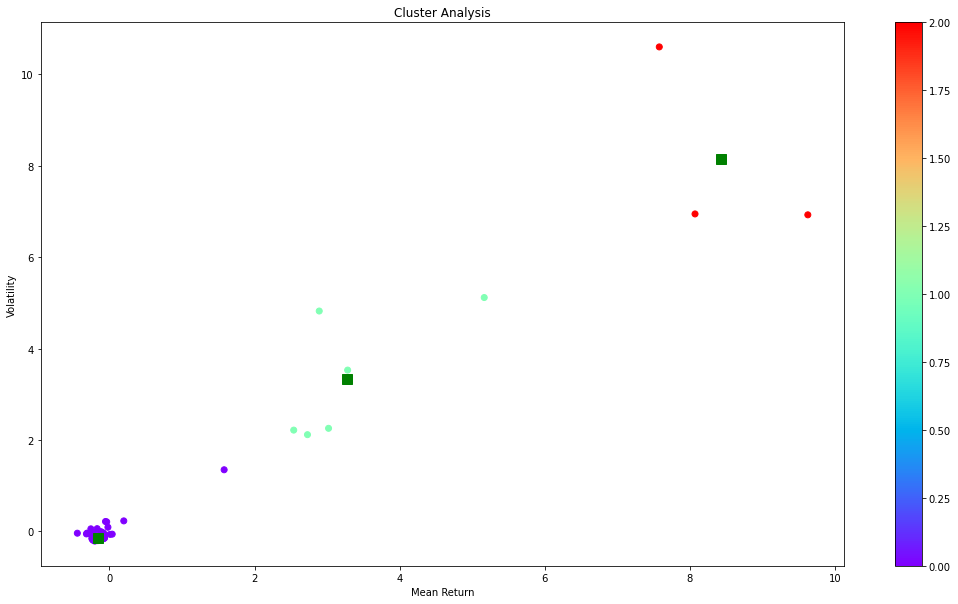

In [16]:
# show results
centroids = kmeans.cluster_centers_
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=kmeans.labels_, cmap='rainbow', label=X.index )
ax.set_title('Cluster Analysis')
ax.set_ylabel('Volatility')
ax.set_xlabel('Mean Return')
plt.colorbar(scatter)
plt.plot(centroids[:,0], centroids[:,1], "sg", markersize=10)
plt.show()

In [17]:
# return the clustered series
clustered_series = pd.Series(index=X.index, data=kmeans.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
clustered_series

AAGIY    0
ACGBY    0
ACHHY    0
ACKAY    0
ADDYY    0
        ..
WMMVY    0
YARIY    0
YZCAY    0
ZLNDY    0
ZURVY    0
Length: 295, dtype: int32

In [18]:
clustered_df = pd.DataFrame(clustered_series)
clustered_df.value_counts()

0    286
1      6
2      3
dtype: int64

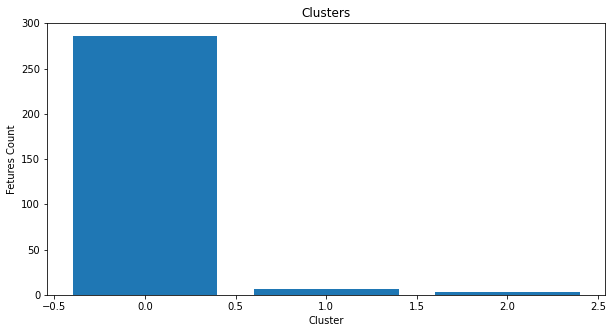

In [19]:
plt.figure(figsize=(10,5))
plt.bar(range(len(clustered_series.value_counts())),clustered_series.value_counts())
plt.title("Clusters")
plt.xlabel("Cluster")
plt.ylabel("Fetures Count")
plt.show()

In [20]:
# if there any significant outliers can be detected it should remove from the dataset, but at this point it has been worked with small kind of test dataset which not contains it.
clustered_series_rem_ol = clustered_series[clustered_series < 3]

#### Calculate Cointegration

In [21]:
def calculate_cointegration(series_1, series_2):
  coint_flag = 0
  coint_result = coint(series_1, series_2)
  coint_t = coint_result[0]
  p_value = coint_result[1]
  critical_value = coint_result[2][1]

  model = simplefilter.OLS(series_1, series_2).fit()
  hedge_ratio = model.params[0]
  coint_flag = 1 if p_value < 0.05 and coint_t < critical_value else 0
  return coint_flag, hedge_ratio

In [ ]:
# loop through and calculate cointegrated pairs
tested_pairs = []
cointegrated_pairs = []

for base_asset in clustered_series_rem_ol.index:
  base_label = clustered_series_rem_ol[base_asset]

  for compare_asset in clustered_series_rem_ol.index:
    compare_label = clustered_series_rem_ol[compare_asset]

    test_pair = base_asset + compare_asset
    test_pair = ''.join(sorted(test_pair))
    is_tested = test_pair in tested_pairs
    tested_pairs.append(test_pair)

    if compare_asset != base_asset and base_label == compare_label and not is_tested:
      series_1 = data[base_asset].values.astype(float)
      series_2 = data[compare_asset].values.astype(float)
      coint_flag, _ = calculate_cointegration(series_1, series_2)
      if coint_flag == 1:
        cointegrated_pairs.append({
            "base_asset": base_asset,
            "compare_asset": compare_asset,
            "label": base_label
        })

df_coint = pd.DataFrame(cointegrated_pairs).sort_values(by="label")
df_coint.head()